<a href="https://colab.research.google.com/github/akshatz/dogVision/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification 

This builds end to end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at a cafe, and I take a photo of a dog, I want to know what breed of dog it is

## 2. Data

The data we're using is from Kaggle's dog breed identification competetion

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:

* We are dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning.

* There are 120 breeds of dogs(this means there are 120 different classes).

* There are 10,000+ images in training set(these images have labels).

* There are 10,000+ images in test set(these images have no labels, becase we'll want to predict them).


In [ ]:
# Unzip  the uploaded data into Google Drive
#!unzip "drive/My Drive/Colab Notebooks/DogVision/*.zip" -d "drive/My Drive/Colab Notebooks/DogVision/" 

# Get our workspace ready

* TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU.


In [ ]:
# Import necessary tools 
import tensorflow as tf
import tensorflow_hub as hub
print("Tensorflow Version:", tf.__version__)
print("TF Hub",hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "Not available")

Tensorflow Version: 2.3.0
TF Hub 0.9.0
GPU available


## Getting data ready(turning into tensors)

Since much of machine learning is getting your data ready to be used with a machine learning model, we'll take extra care getting it setup.

There are a few ways we could do this. Many of them are detailed in the [Google Colab notebook on I/O (input and output)](https://colab.research.google.com/notebooks/io.ipynb).

And because the data we're using is hosted on Kaggle, we could even use the [Kaggle API](https://www.kaggle.com/docs/api).

This is great but what if the data you want to use wasn't on Kaggle?

One method is to upload it to your Google Drive, mount your drive in this notebook and import the file.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Colab Notebooks/DogVision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     e401d9046968cb01f5bdb97f92e61428  scottish_deerhound
freq                                   1                 126


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


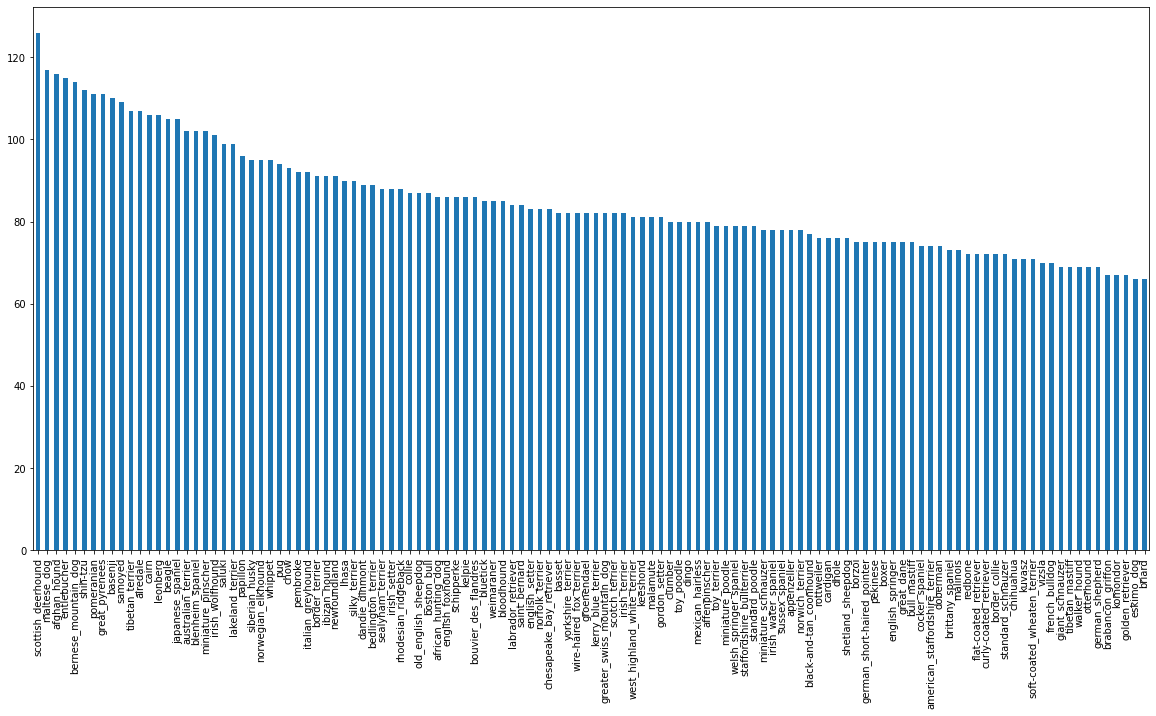

In [ ]:
labels_csv.breed.value_counts().plot.bar(figsize=(20,10));

In [ ]:
labels_csv.breed.value_counts().median()

82.0

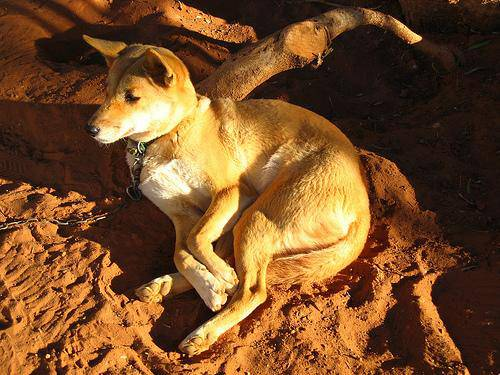

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Colab Notebooks/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting Images and their labels

Let's get list of all of our image file pathnames

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Create  path names from image ID's
filenames = ["drive/My Drive/DogVision/train/"+fname + ".jpg" for fname in labels_csv.id]

# Check the first 10
filenames

['drive/My Drive/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/DogVision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/DogVision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/DogVision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/DogVision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/DogVision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/DogVision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/DogVision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/DogVision/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'drive/My Drive/DogVision/train/004396df1acd0f1247b740ca2b14616e.jpg',
 'drive/My Drive/DogVision/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 'drive/My Drive/DogVision/train/00693b8bc2470375cc744a6391d397ec.jpg',
 'drive/My Drive/DogVision/train/006cc3ddb9dc1bd827479569fcdc52d

In [ ]:
# Check whether no of filenames matches no of actual image files
import os
if len(os.listdir("drive/My Drive/DogVision/train/")) == len(filenames):
  print("Matches. You can proceed")
else:
  print("Check the target directory")

Matches. You can proceed


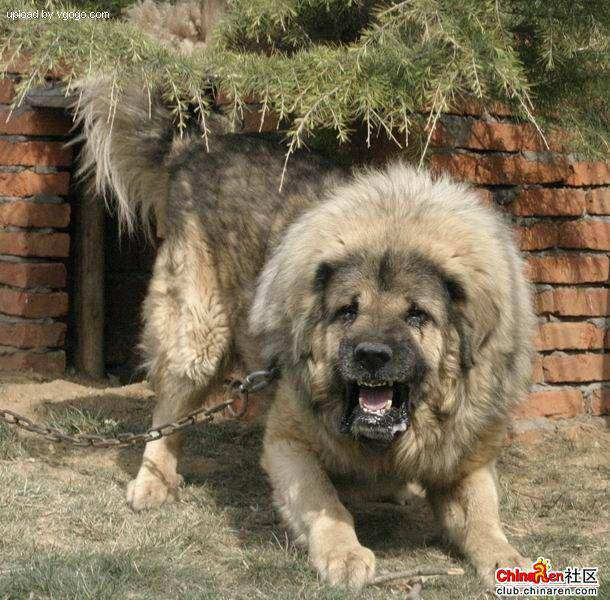

In [ ]:
# One more check
Image(filenames[9000])

In [ ]:
labels_csv.breed[9000]

'tibetan_mastiff'

In [ ]:
import numpy as np

labels = labels_csv.breed.to_numpy()
#labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if no of labels matches with no of filenames
if len(labels) == len(labels_csv):
  print("Matches")
else:
  print("Not matches")

Matches


In [ ]:
# Find unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120